In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from termcolor import colored
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, auc, roc_curve


In [23]:
X_train, X_test, Y_train, Y_test = load('C:/Users/Administrator/2023_Data_Mining_Coffee_Quality_Dataset/classification_data.joblib')
print(X_train.shape, X_test.shape)

(888, 10) (438, 10)


In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
model_rf=load('random_forest.pkl')
model_dt=load('decision_tree.pkl')
model_knn=load('cv_knn.pkl')
model_svm=load('svm.pkl')

In [26]:
model_rf

RandomForestClassifier(max_depth=10, n_estimators=200)

In [27]:
model_dt

DecisionTreeClassifier(max_depth=8)

In [28]:
model_knn

KNeighborsClassifier(n_neighbors=15)

In [29]:
model_svm

SVC(C=100, gamma=10, probability=True)

In [30]:
def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled

In [31]:
# svi modeli osim knn rade na balansiranim podacima

smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = resample(smoteenn, X_train, Y_train)

Number of instances before resampling with SMOTEENN : dict_items([(8.0, 104), (7.0, 532), (6.0, 194), (4.0, 15), (9.0, 11), (5.0, 32)]). 
Number of instances after  resampling with SMOTEENN : dict_items([(4.0, 467), (5.0, 425), (6.0, 192), (7.0, 123), (8.0, 296), (9.0, 488)]). 


In [32]:
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred,zero_division=1.0))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=[4,5,6,7,8,9], index=[4,5,6,7,8,9]))
    print("---------------------------------------------------------------------------------")
    return y_pred

In [33]:
def build_model(model, X_train, X_test, y_train, y_test):
    y_train_pred=report(model, X_train, y_train, "training")
    y_pred=report(model,X_test, y_test,"test")

    return y_train_pred, y_pred

In [34]:
y_train_pred_values = []
y_pred_values = []
for model in [model_svm,model_dt,model_rf]:
    y_train_pred, y_pred = build_model(model, X_resampled, X_test, y_resampled, Y_test)
    y_train_pred_values.append(y_train_pred)
    y_pred_values.append(y_pred)


y_train_pred, y_pred = build_model(model_knn, X_train, X_test, Y_train, Y_test)
y_train_pred_values.append(y_train_pred)
y_pred_values.append(y_pred)


Classification report for model SVC on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

         4.0       1.00      1.00      1.00       467
         5.0       1.00      1.00      1.00       425
         6.0       1.00      0.99      1.00       192
         7.0       0.99      0.99      0.99       123
         8.0       0.99      0.98      0.98       296
         9.0       0.99      1.00      0.99       488

    accuracy                           0.99      1991
   macro avg       1.00      0.99      0.99      1991
weighted avg       0.99      0.99      0.99      1991

---------------------------------------------------------------------------------
Confusion matrix for model SVC on training data 
---------------------------------------------------------------------------------
     4    5    6    7    8    9
4  467    0    0    0    0    0
5    1  424    0    0    0    0
6    0    0  

              precision    recall  f1-score   support

         4.0       1.00      1.00      1.00       467
         5.0       1.00      1.00      1.00       425
         6.0       1.00      1.00      1.00       192
         7.0       1.00      0.98      0.99       123
         8.0       0.99      0.98      0.99       296
         9.0       0.99      1.00      0.99       488

    accuracy                           1.00      1991
   macro avg       1.00      0.99      0.99      1991
weighted avg       1.00      1.00      1.00      1991

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on training data 
---------------------------------------------------------------------------------
     4    5    6    7    8    9
4  467    0    0    0    0    0
5    0  425    0    0    0    0
6    0    0  192    0    0    0
7    0    0    0  120    2    1
8    0    0    0    0  290    6
9    0    0    0    0    0  488
-

In [35]:
micro_precision_train = []
macro_precision_train = []
micro_recall_train = []
macro_recall_train = []

micro_precision_test = []
macro_precision_test = []
micro_recall_test = []
macro_recall_test = []

for i,y_train_pred, y_pred in zip(range(1,5),y_train_pred_values, y_pred_values):
    if i<4:
        micro_precision_train.append(precision_score(y_resampled, y_train_pred,average="micro"))
        macro_precision_train.append(precision_score(y_resampled, y_train_pred,average="macro"))
        micro_recall_train.append(recall_score(y_resampled, y_train_pred,average="micro"))
        macro_recall_train.append(recall_score(y_resampled, y_train_pred,average="macro"))
    else:
        micro_precision_train.append(precision_score(Y_train, y_train_pred,average="micro"))
        macro_precision_train.append(precision_score(Y_train, y_train_pred,average="macro"))
        micro_recall_train.append(recall_score(Y_train, y_train_pred,average="micro"))
        macro_recall_train.append(recall_score(Y_train, y_train_pred,average="macro"))

    micro_precision_test.append(precision_score(Y_test, y_pred,average="micro"))
    macro_precision_test.append(precision_score(Y_test, y_pred,average="macro"))
    micro_recall_test.append(recall_score(Y_test, y_pred,average="micro"))
    macro_recall_test.append(recall_score(Y_test, y_pred,average="macro"))

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0.98, 'Training data')

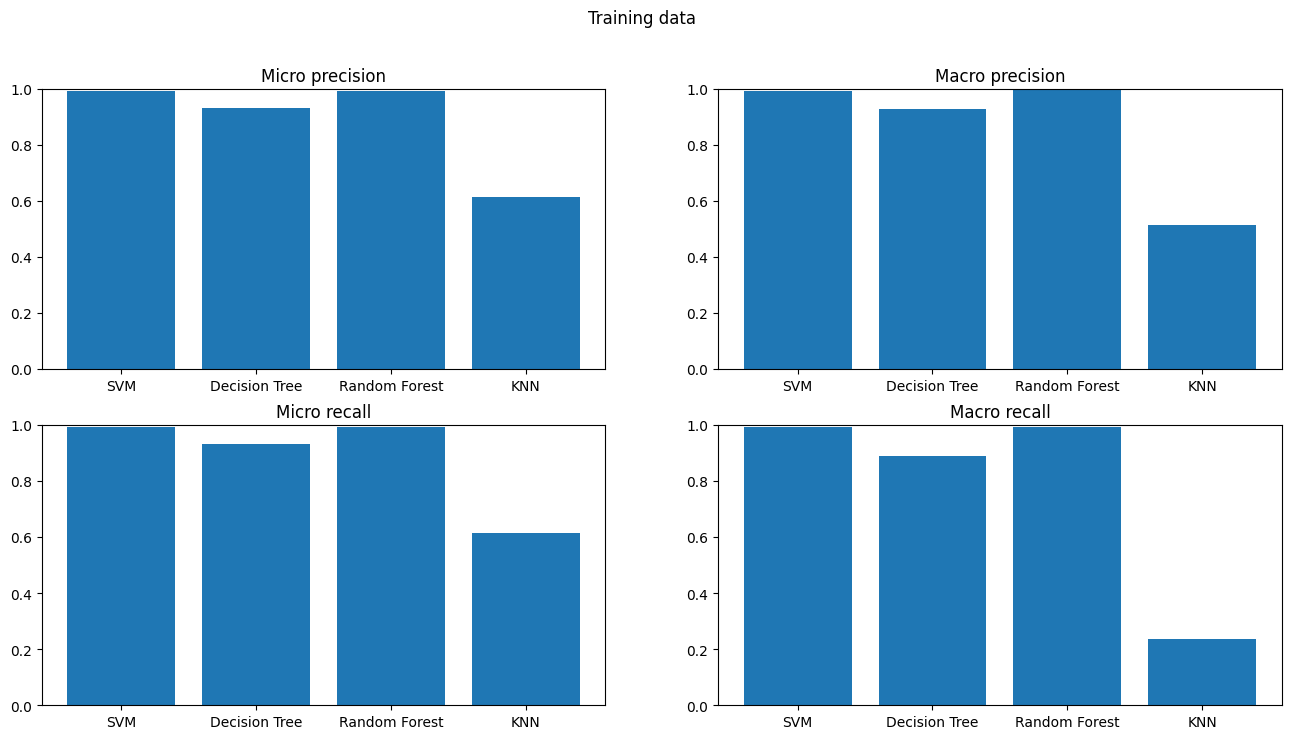

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

names= ['SVM', 'Decision Tree', 'Random Forest', 'KNN']

axes[0, 0].bar(names, micro_precision_train)
axes[0, 0].set_title('Micro precision')
axes[0, 0].set_ylim(0, 1)

axes[0, 1].bar(names, macro_precision_train)
axes[0, 1].set_title('Macro precision')
axes[0, 1].set_ylim(0, 1)

axes[1, 0].bar(names, micro_recall_train)
axes[1, 0].set_title('Micro recall')
axes[1, 0].set_ylim(0, 1)

axes[1, 1].bar(names, macro_recall_train)
axes[1, 1].set_title('Macro recall')
axes[1, 1].set_ylim(0, 1)

fig.suptitle("Training data")

Text(0.5, 0.98, 'Test data')

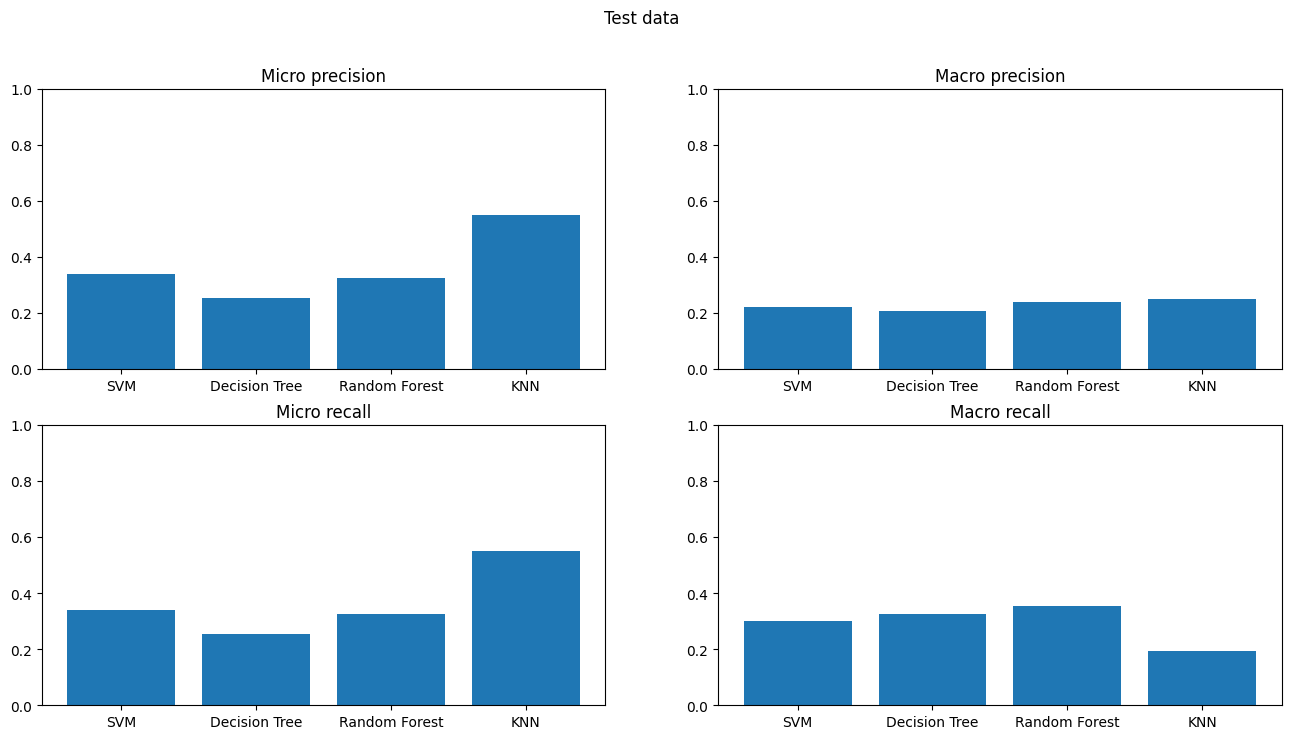

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

names= ['SVM', 'Decision Tree', 'Random Forest', 'KNN']

axes[0, 0].bar(names, micro_precision_test)
axes[0, 0].set_title('Micro precision')
axes[0, 0].set_ylim(0, 1)

axes[0, 1].bar(names, macro_precision_test)
axes[0, 1].set_title('Macro precision')
axes[0, 1].set_ylim(0, 1)

axes[1, 0].bar(names, micro_recall_test)
axes[1, 0].set_title('Micro recall')
axes[1, 0].set_ylim(0, 1)

axes[1, 1].bar(names, macro_recall_test)
axes[1, 1].set_title('Macro recall')
axes[1, 1].set_ylim(0, 1)

fig.suptitle("Test data")

In [38]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape

(438, 6)

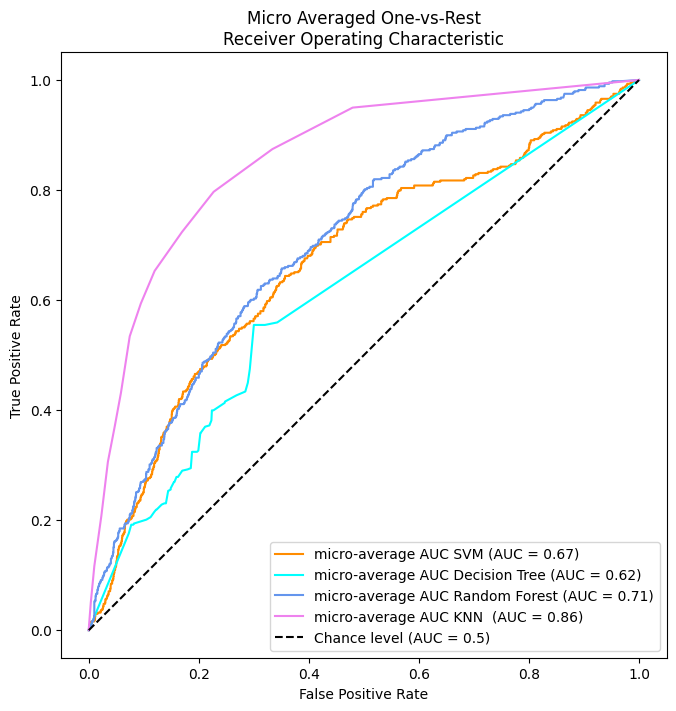

In [39]:

y_score=model_svm.fit(X_resampled, y_resampled).predict_proba(X_test)
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(14, 7),layout="constrained" )
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average AUC SVM",
    color="darkorange",
    plot_chance_level=False,
    ax=ax1
    
)
y_score=model_dt.fit(X_resampled, y_resampled).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average AUC Decision Tree",
    color="aqua",
    plot_chance_level=False,
    ax=ax1
    
)
y_score=model_rf.fit(X_resampled, y_resampled).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average AUC Random Forest",
    color="cornflowerblue",
    plot_chance_level=False,
    ax=ax1
    
)
y_score=model_knn.fit(X_train, Y_train).predict_proba(X_test)
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average AUC KNN ",
    color="violet",
    plot_chance_level=True,
    ax=ax1
    
)


plt.axis("square")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Micro Averaged One-vs-Rest\nReceiver Operating Characteristic")

plt.legend()
plt.show()

In [40]:
n_classes=6

In [41]:
def macro_avg(y_onehot_test,y_score): #scikitlearn
    fpr=[0 for i in range(0,n_classes)]
    tpr=[0 for i in range(0,n_classes)]
    roc_auc=[0 for i in range(0,n_classes)]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr = fpr_grid
    tpr = mean_tpr
    roc_auc= auc(fpr, tpr)
    #print(fpr)
    return fpr, tpr, roc_auc

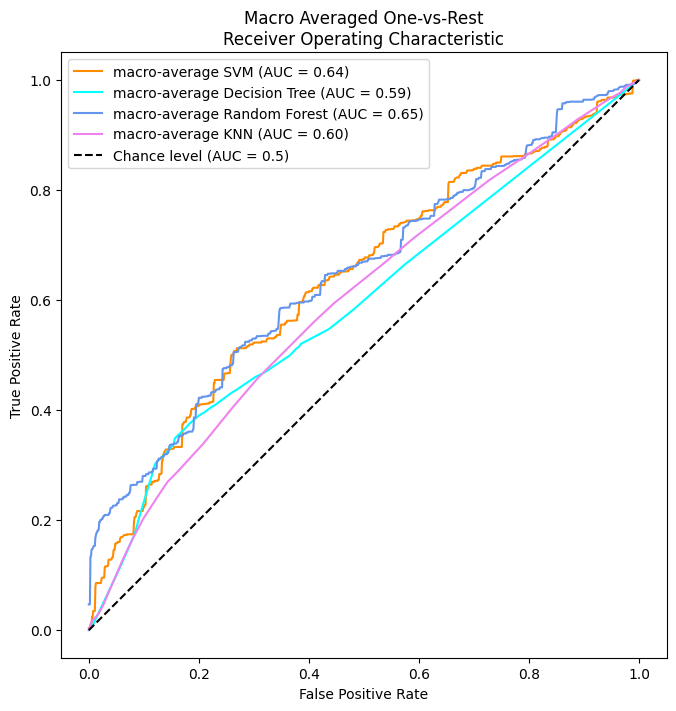

In [42]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(14, 7),layout="constrained" )
y_score=model_svm.fit(X_resampled, y_resampled).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f"macro-average SVM (AUC = {roc_auc:.2f})",
    color="darkorange",
    
    
)
y_score=model_dt.fit(X_resampled, y_resampled).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f"macro-average Decision Tree (AUC = {roc_auc:.2f})",
    color="aqua",
    
    
)
y_score=model_rf.fit(X_resampled, y_resampled).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f"macro-average Random Forest (AUC = {roc_auc:.2f})",
    color="cornflowerblue",
    
    
)
y_score=model_knn.fit(X_train, Y_train).predict_proba(X_test)
fpr,tpr,roc_auc=macro_avg(y_onehot_test,y_score)
ax1.plot(
    fpr,
    tpr,
    label=f"macro-average KNN (AUC = {roc_auc:.2f})",
    color="violet",
    
    
)
ax1.plot([0, 1], [0, 1], label='Chance level (AUC = 0.5)', color='black',linestyle='dashed')




plt.axis("square")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")

ax1.set_title("Macro Averaged One-vs-Rest\nReceiver Operating Characteristic")

ax1.legend()

plt.show()